# Preparation of initial box for coexsistence simulations

In [2]:
import numpy as np, sys, os, glob
import matplotlib.pylab as plt
import MDAnalysis
import pickle

In [3]:
standard_sim=os.path.abspath('template/')
press_box = np.genfromtxt('../2-Bulk/avg_IceIII_box.dat')
single_pressure=None #'7000'
#temps=np.array([245,250,255,260,265,270])

In [4]:
### First step: equilibrate ice box

In [5]:
sims = dict()
for a in press_box[:]:
    fold='BOX_EQUIL_{}bar/'.format(a[0])
    if single_pressure==None or single_pressure in fold:
        sims[fold] = dict()
        sims[fold]['p']=a[0]
        os.system('mkdir -p {}'.format(fold))
        os.system('cp -r {}/* {}'.format(standard_sim,fold))
        cmd='sed -i "" "s#variable .* pressure .*#variable        pressure equal {}#g" {}/in.pressure'.format(sims[fold]['p'],fold)
        os.system(cmd)

### Second step: Determine average box dimensions

In [6]:
def extract_form_log(fn):
    lines=open(fn,'r').readlines()
    start=np.where([('Step' in l) for l in lines])[-1][0]
    data={keyi.lower(): []  for keyi in lines[start].split()}
    for l in lines[start+1:]:
        ls=l.split()
        try:
            if ls[0].isdigit():
                for i, key in enumerate(data.keys()):
                    data[key].append(float(ls[i]))
        
            else:
                break
        except:
            break
    for key in data.keys():
        data[key]=np.array(data[key])
    return data

In [17]:
box_equil=dict()
for f in glob.glob('BOX_EQUIL_*/log.lammps'): 
    box_equil[f.replace('/log.lammps','')]=extract_form_log(f)


with open('box_size.pickle', 'wb') as handle:
    pickle.dump(box_equil, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('box_size.pickle', 'rb') as handle:
    box_equil = pickle.load(handle)
print(box_equil.keys())

dict_keys(['BOX_EQUIL_2000.0bar', 'BOX_EQUIL_6000.0bar', 'BOX_EQUIL_3000.0bar', 'BOX_EQUIL_7000.0bar', 'BOX_EQUIL_5000.0bar', 'BOX_EQUIL_2500.0bar', 'BOX_EQUIL_4000.0bar'])


Text(0, 0.5, 'v/Å$^3$')

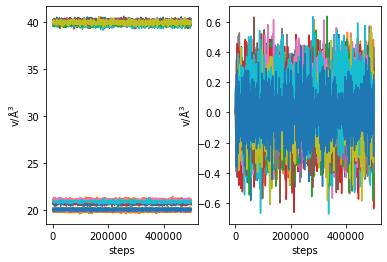

In [18]:
plt.subplot(121)

for key in box_equil.keys():
    plt.plot(box_equil[key]['step'],box_equil[key]['lx'])
    plt.plot(box_equil[key]['step'],box_equil[key]['lz'])
    plt.plot(box_equil[key]['step'],box_equil[key]['ly'])
plt.xlabel('steps')
plt.ylabel(r'v/Å$^3$')
plt.subplot(122)
for key in box_equil.keys():
    plt.plot(box_equil[key]['step'],box_equil[key]['xy'])
    plt.plot(box_equil[key]['step'],box_equil[key]['xz'])
    plt.plot(box_equil[key]['step'],box_equil[key]['yz'])
plt.xlabel('steps')
plt.ylabel(r'v/Å$^3$')

In [15]:
for fold in box_equil.keys():
    sim=box_equil[fold]
    #print(sim)                                                                                                                                                                              
    # Scale box                                                                                                                                                                              
    u = MDAnalysis.Universe(fold+'/ice_equil.data', in_memory=True)
    NIGNORE=int(0.25*len(box_equil[key]['step']))
    print('before',u.dimensions)
    lx=np.mean(sim['lx'][NIGNORE:])
    xy=np.mean(sim['xy'][NIGNORE:])
    xz=np.mean(sim['xz'][NIGNORE:])
    ly=np.mean(sim['ly'][NIGNORE:])
    yz=np.mean(sim['yz'][NIGNORE:])
    print(sim['yz'][NIGNORE:])
    lz=np.mean(sim['lz'][NIGNORE:])
    print(xy,xz,yz)
    A=np.array([[lx,0,0],
                 [xy,ly,0],
                 [xz,yz,lz]])
    dimensions_new=MDAnalysis.lib.mdamath.triclinic_box(A[0], A[1], A[2])
    print('after',dimensions_new)
    u.coord.positions[:,0] = u.coord.positions[:,0]*lx/u.dimensions[0]
    u.coord.positions[:,1] = u.coord.positions[:,1]*ly/u.dimensions[1]
    u.coord.positions[:,2] = u.coord.positions[:,2]*lz/u.dimensions[2]
    u.dimensions=dimensions_new
    u.atoms.write(fold+'/ice_avg_equil.data')

/Users/sigbjobo/miniforge3/lib/python3.9/site-packages/MDAnalysis/coordinates/base.py:892: UserWarning: Reader has no dt information, set to 1.0 ps
  warnings.warn("Reader has no dt information, set to 1.0 ps")


before [40.065453 20.091324 21.008356 90.67325  89.42535  90.15939 ]
[-1.2848762e-01  8.7618778e-02  1.6669396e-01 -1.4079015e-01
 -1.9585203e-01  2.6718273e-01  2.3364547e-01 -2.1768999e-01
 -6.9023189e-02  1.5088559e-01 -3.1382615e-02 -8.8794818e-02
  8.2465308e-02  1.3299618e-01 -7.9861898e-02 -8.2345733e-02
  1.2017774e-01  6.4570673e-02 -1.2146565e-01 -3.4335550e-02
  1.7159480e-01  9.4779986e-02 -1.9327352e-01 -7.5149396e-02
  1.2363322e-01 -4.2485137e-02 -3.0476584e-01 -1.0411617e-03
  3.0306899e-01 -1.7261724e-01 -2.2414046e-01  3.2691295e-01
  1.7830493e-01 -2.5279034e-01 -1.9999773e-01  2.5906925e-01
  3.3181328e-01 -2.3370155e-01 -1.9472031e-01  3.1769637e-01
  2.5102193e-01 -2.2984632e-01 -1.6776554e-01  1.8412221e-01
  8.4636535e-02 -3.0826763e-01 -1.6810145e-01  3.1563663e-01
  4.5187397e-02 -2.6993871e-01 -4.2329994e-02  2.3444558e-01
  1.9205601e-02 -2.3194039e-01  7.3258293e-02  1.2475557e-01
 -5.2897093e-02 -1.0426458e-01  6.2726650e-02  9.5060971e-03
 -1.7356231e-02 

dict_items([('bond', <TopologyGroup containing 1296 bonds>), ('angle', <TopologyGroup containing 648 angles>), ('dihedral', <TopologyGroup containing 0 dihedrals>), ('improper', <TopologyGroup containing 0 impropers>)])
bond ['1']
angle ['1']
dihedral []
improper []
before [39.69237  19.92664  20.724478 89.17327  90.39157  90.66219 ]
[ 1.8545733e-01 -1.1583796e-02 -1.5484668e-01 -1.9355973e-02
  1.6680253e-02  4.2571711e-02 -6.1964048e-04 -6.6857952e-02
  6.8972238e-02  6.7021521e-02 -2.5106061e-01 -8.7074663e-02
  2.1175765e-01  2.1991860e-02 -1.3887661e-01  1.5701057e-02
  1.1617548e-01 -1.1374611e-01 -5.9304001e-02  6.4743759e-02
 -5.9433899e-02 -5.3088476e-02  1.3513183e-01 -1.2866712e-02
 -1.3405564e-01  1.1961528e-01  1.6879920e-01 -1.5190456e-01
 -1.6265560e-01  7.7559204e-02  5.7742579e-02 -1.6721657e-01
 -9.4519395e-02 -5.2374867e-03  1.0421786e-01 -2.1643596e-02
 -1.0896579e-01  3.6410833e-02  3.1268539e-02  2.0735310e-02
  4.0135355e-02 -8.9829898e-02  3.4397072e-02  1.45431

dict_items([('bond', <TopologyGroup containing 1296 bonds>), ('angle', <TopologyGroup containing 648 angles>), ('dihedral', <TopologyGroup containing 0 dihedrals>), ('improper', <TopologyGroup containing 0 impropers>)])
bond ['1']
angle ['1']
dihedral []
improper []
before [40.034374 20.00253  20.940891 89.98972  89.400734 89.91912 ]
[ 1.8897700e-02  4.4456625e-02 -2.3767610e-02 -3.6566244e-02
  2.1781606e-02  3.8990460e-02  5.8951834e-02  1.5603769e-01
 -1.2462458e-01 -2.2889203e-01  1.1859193e-01  1.2667439e-01
 -2.0885592e-01 -5.0201324e-01  6.8006322e-02  2.8147755e-01
 -8.6866809e-02 -1.6777124e-01  1.2225478e-01  1.1109109e-01
 -1.8949037e-01 -6.9233512e-02  1.3833014e-01  3.7426839e-02
 -2.5443234e-01 -1.0162298e-01  2.6246312e-01  1.9926266e-02
 -1.7910163e-01  8.1838267e-02  1.8006627e-01 -1.2060716e-01
 -2.5393098e-01  1.1260418e-01  1.0552316e-01 -2.1011284e-01
 -8.5198352e-02  1.7525692e-01  1.0467858e-01 -2.3643681e-01
 -2.6077320e-01  3.5712569e-01  2.5694962e-01 -2.30905

dict_items([('bond', <TopologyGroup containing 1296 bonds>), ('angle', <TopologyGroup containing 648 angles>), ('dihedral', <TopologyGroup containing 0 dihedrals>), ('improper', <TopologyGroup containing 0 impropers>)])
bond ['1']
angle ['1']
dihedral []
improper []
before [39.762676 19.920511 20.57964  90.57305  89.00138  90.644745]
[-4.4302304e-02  4.7831439e-02 -4.3001944e-03 -8.0056649e-02
 -2.6326997e-02 -4.4739299e-04  2.0626668e-02 -1.3875650e-02
 -4.1901058e-02  7.0990185e-02  5.9950178e-02 -8.1580578e-02
 -9.9159527e-03  3.7584597e-02 -1.8740300e-01 -1.6071788e-01
 -9.3323599e-03  8.2736445e-02  3.5145401e-02 -5.7881496e-02
 -7.6362801e-02  1.0668687e-01 -1.9981312e-02 -2.0964096e-01
  1.0512904e-01  9.8000153e-02 -1.0962653e-01 -1.1079855e-01
  2.8789063e-01  7.8556918e-02 -2.5659519e-01  1.1019978e-01
  1.8886382e-01 -1.9925177e-01 -1.9715973e-01  2.5446499e-01
  9.4783413e-02 -1.4485921e-01 -5.8936381e-02  1.7848005e-01
  3.1211676e-02 -2.0250175e-01  9.3866915e-04  2.01675

dict_items([('bond', <TopologyGroup containing 1296 bonds>), ('angle', <TopologyGroup containing 648 angles>), ('dihedral', <TopologyGroup containing 0 dihedrals>), ('improper', <TopologyGroup containing 0 impropers>)])
bond ['1']
angle ['1']
dihedral []
improper []
before [40.109753 20.027807 20.530373 89.59021  89.233475 90.20839 ]
[ 4.6179941e-02 -5.8697163e-02  2.9487282e-02  7.7108071e-02
 -8.0021273e-02 -5.1621652e-02  4.4274861e-02  1.5275564e-02
 -1.0447927e-01  2.0878143e-02  1.3873502e-01 -6.4634396e-03
 -1.4872578e-01  8.4526684e-03  8.4672908e-02 -3.2316089e-02
 -9.9657407e-02  1.1527038e-01  1.8371181e-02  4.2324097e-02
  1.3541820e-01 -1.0092076e-03 -3.9114807e-03 -1.1366055e-02
  8.2204755e-02  6.4754310e-02 -7.7995987e-02 -4.0344011e-02
  1.0154280e-01 -1.0682619e-02  3.0603046e-02  1.5978464e-01
  2.5412390e-02 -1.2665558e-01 -5.2060548e-02  9.4594365e-02
  4.2375676e-02  7.3997747e-02 -9.5230244e-02 -6.7473151e-02
  1.6406349e-01  1.4485590e-01 -1.4520450e-01 -9.48015

dict_items([('bond', <TopologyGroup containing 1296 bonds>), ('angle', <TopologyGroup containing 648 angles>), ('dihedral', <TopologyGroup containing 0 dihedrals>), ('improper', <TopologyGroup containing 0 impropers>)])
bond ['1']
angle ['1']
dihedral []
improper []
before [40.060863 20.090311 20.798986 90.33763  89.58862  88.7824  ]
[ 6.6254269e-02  1.5609633e-01 -1.7424632e-01 -1.9549988e-01
  2.2019934e-01  1.2903445e-01 -1.8821674e-01 -7.0501515e-02
  7.1120888e-02  6.4038660e-02  3.4555989e-02 -8.3929677e-03
 -9.1032630e-04  1.2871509e-02  1.5332713e-02 -4.3541154e-02
 -1.0960724e-01  6.2502437e-02  2.0651692e-01  2.8643187e-03
 -2.0079127e-01 -9.9153122e-02  5.8266559e-02 -2.0055397e-02
  1.0223584e-02 -4.7451994e-02 -1.7400209e-02 -9.2052433e-03
  1.1762395e-01  3.5414697e-02 -1.9190324e-01 -9.7237208e-02
  2.0991558e-01  6.1186859e-02 -1.6910613e-01 -2.3569451e-02
  2.1248916e-01 -9.9289346e-02 -3.6670949e-01  9.1006973e-02
  1.5182124e-01 -1.7250920e-01 -2.8835816e-01  2.85286

before [40.060146 20.000399 20.839708 89.31292  89.575226 89.236824]
[ 1.2900651e-01 -7.6793179e-02 -3.9763195e-02  1.0149274e-01
  9.8221914e-02 -1.1777790e-01 -1.7817662e-01  1.7460427e-01
  5.7723516e-02 -2.1478964e-01 -9.7398527e-04  2.1410252e-01
 -8.5593180e-02 -4.4371931e-01 -7.3154847e-02  1.8435088e-01
 -2.9765962e-02 -2.4573572e-01  1.2256204e-01  2.4188970e-01
 -1.2805437e-01 -2.9024215e-02  2.1461426e-01  2.7532206e-02
 -1.2048846e-01  7.4068185e-02  1.0417877e-01 -6.5422492e-02
 -8.0991335e-02  2.2835957e-02 -1.7265493e-02 -2.2615291e-02
  1.1578715e-02 -1.1234205e-02 -6.8503768e-02  1.0821098e-02
  8.7640159e-02 -9.5564076e-02 -1.6991125e-01  1.4676165e-01
  1.5019449e-01 -2.4364873e-01 -2.1551002e-01  2.7070282e-01
  1.6850469e-01 -1.6419596e-01 -1.8682439e-02  1.0979094e-01
 -1.1891721e-02 -2.4233505e-01 -2.2851085e-02  7.1489726e-02
 -1.0776318e-01 -7.2653156e-02  6.5565523e-02  8.0574482e-02
 -3.6975553e-02 -1.8058313e-01 -1.5446247e-02  1.2032036e-01
  2.2543707e-02 

dict_items([('bond', <TopologyGroup containing 1296 bonds>), ('angle', <TopologyGroup containing 648 angles>), ('dihedral', <TopologyGroup containing 0 dihedrals>), ('improper', <TopologyGroup containing 0 impropers>)])
bond ['1']
angle ['1']
dihedral []
improper []


### Third step: Melt half the box

In [12]:
for a in press_box[:]:
    fold='BOX_MELT_{}bar/'.format(a[0])
    os.system('mkdir -p {}'.format(fold))
    os.system('cp -r {}/ice_avg_equil.data {}'.format(fold.replace('MELT','EQUIL'),fold))
    os.system('cp -r {}/* {}'.format(standard_sim,fold))
    cmd='sed -i "" "s#variable .* pressure .*#variable        pressure equal {}#g" {}/in.pressure'.format(a[0],fold)
    os.system(cmd)

### Fourth step: collect data files

In [13]:
fold_out='COEX_BOXES/'
os.system('mkdir -p {}'.format(fold_out))
for a in press_box[:]:
    fold='BOX_MELT_{}bar/'.format(a[0])
    os.system('cp {}/water.data.equil {}/{}'.format(fold,fold_out,'water_{}bar.data'.format(a[0])))

### Convert notebook to python script

In [1]:
!jupyter nbconvert --to script Prepare_coexsistence.ipynb


[NbConvertApp] Converting notebook Prepare_coexsistence.ipynb to script
[NbConvertApp] Writing 3646 bytes to Prepare_coexsistence.py
